# Prediction of Involvement of Drunk Drivers in Fatal Highway Crashes
## Machine Learning

### Chester Hitz | Springboard Data Science Career Track | Capstone II

Following a pivot from my original capstone idea, I am trying to identify the involvement of at least one drunk driver in a fatal car crash, using the extensive dataset from the Fatality Analysis Reporting System. This is a massive dataset, but I am trying to predict based on a limited number of variables, namely:

* Timing: Time of day and day of week.
* Crash events: Contained within the five PCRASH variables is a sequence of 5 steps that happen in every crash, with each step describing a different event. More description in section.
* Various other factors: Involvement of speeding and road type.

Various insights about the data can be read about in the [EDA portion](https://github.com/cwhitz/Springboard-Capstone-1/blob/master/Accidents%20EDA.ipynb) of this capstone. The aim of this portion is to select, tune, and test the best machine learning algorithm to attain the most accurate predictions of the target variable, DRUNK_INV, which indicates the involvement of at least one drunk driver.

To start, I import the standard libraries plus sklearn librries for preprocessing and metrics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# general sklearn tools for preprocessing and metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# data import
df = pd.read_csv('Accidents_ML.csv')

# validate data load
print(df.shape)
print(df.info())

(224992, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224992 entries, 0 to 224991
Data columns (total 22 columns):
Unnamed: 0        224992 non-null int64
index             224992 non-null int64
DRUNK_INV         224992 non-null bool
HOUR              224992 non-null int64
DAY_WEEK          224992 non-null int64
LGT_COND          224992 non-null int64
CF1               224992 non-null int64
CF2               224992 non-null int64
CF3               224992 non-null int64
P_CRASH1          224992 non-null int64
P_CRASH2          224992 non-null int64
P_CRASH3          224992 non-null int64
PCRASH4           224992 non-null int64
PCRASH5           224992 non-null int64
VSPD_LIM          215483 non-null float64
TRAV_SP           83159 non-null float64
FATALS            224992 non-null int64
ROUTE             224992 non-null int64
corrected_HOUR    224992 non-null int64
Weekend           224992 non-null int64
OverSpeedLimit    81918 non-null float64
road_type         224992 non-null

## Data Preprocessing
The first task is to make the many categorical variables in the dataset more expressive and machine-readable. Currently the variables are encoded with integers, each representing a different category of something. However, those integers are merely symbolic and have no linear nor ordinal relationship to one and other. Therefore, it is easier for sklearn's models to read the categories when the categories are fleshed out to new columns with binary values, showing whether that particular record is in a certain category (represented by a 1) or not (0). This ends up creating *n* columns, where *n* is the total number of unique categories in the column. 

Below, nine categorical columns are transformed into binary representation via the use of sklearn's OneHotEncoder().

In [3]:
cat_features = ['CF1','CF2','CF3','P_CRASH1','P_CRASH2','P_CRASH3','PCRASH4','PCRASH5', 'ROUTE']
df.drop(['road_type','Unnamed: 0','index','HOUR'], axis=1, inplace=True)

n_cols=df.shape[1]

enc = OneHotEncoder(sparse=False)

# this code block loops through the specified categorical features in the dataframe and performs
# an OHE transformation on them, then concats them back to the dataframe
for feature in cat_features:
    mtx = df[feature].values.reshape(len(df), 1)
    mtx = enc.fit_transform(mtx)
    
    c_names= [feature+'_'+str(enc.active_features_[x]) for x in range(mtx.shape[1])]
    mtx_df = pd.DataFrame(mtx, index=df.index, columns=c_names)
    df = df.drop(feature, axis=1)
    df = pd.concat([df, mtx_df], axis=1)
    
'n columns added to dataframe: ' + str(df.shape[1] - n_cols)

'n columns added to dataframe: 167'

Note that the column names have the integer keys they represent preserved via code on line 14. 

The next step is to try some different models on the data, but not before some standard preprocessing is performed.

In [4]:
# split off the target array from the data, then split train/test data at customary 80-20 ratio
y = df['DRUNK_INV']
X = df.drop(['DRUNK_INV','VSPD_LIM','TRAV_SP','OverSpeedLimit'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=.8, test_size=.2)

## Decision Tree and Random Forest Classifiers

The first models to try are the decision tree classifiers. A function is defined below to test models, and then a simple DecisionTreeClassifier is passed into it.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def dt_pipeline(model, model_return=False):
    m = model.fit(X_train, y_train)
    predictions = m.predict(X_test)
    train_accuracy = m.score(X_train, y_train)
    test_accuracy = m.score(X_test, y_test)
    if model_return:
        return m
    print("Accuracy | Training : ", train_accuracy)
    print("Accuracy | Test     : ", test_accuracy)

dt_pipeline(DecisionTreeClassifier(random_state=42))

The decision tree seems to be overfitting to the training data, resulting in lower test accuracy relative to training accuracy. Using an ensemble method, RandomForestClassifier, might have a better accuracy rate than just building a single decision tree, as it builds an ensemble of trees based off various bootstrap subsets of the data, then finds the average between them.

In [33]:
rfc = dt_pipeline(RandomForestClassifier(random_state=42), model_return=True)

One appreciable aspect of the decision tree classifier is how stunningly interpretable it is in context of this case, especially when it comes to the crash factors and pre-crash movements. As covered in the EDA section of my capstone, the pre-crash movement variables describe a story of a crash through categorical variables, where each of the five variables (P_CRASH1 - P_CRASH5) is a different step that led to the crash. Therefore each brach of the decision tree through the five precrash steps represents a complete set of actions action. For example, the decision tree learns that values like 1 in P_CRASH3, indicating that no avoidance maneuver was taken by the driver to avoid an accident, mean the driver was more likely to be impaired. 

Examining the feature importances can provide insight into what features are most important in the decision tree ensemble. In this case, I reverse the processing done in my preprocessing step with OneHotEncoder to aggregate the feature importances of each categorical variable.


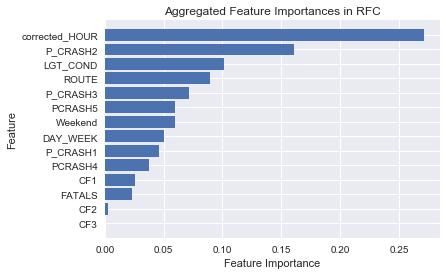

In [28]:
# create series of top features, index set to those features
rfc_top_features = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values()

# create seperate series to aggregate
rfc_top_features_agg = rfc_top_features.copy()

# aggregate categorical features based on common column titles
for cat in cat_features:
    all_sub_features = rfc_top_features[[x for x in list(rfc_top_features.index) if cat in x]]
    rfc_top_features_agg[cat] = np.sum(all_sub_features)
    # drop subcategories
    rfc_top_features_agg.drop(all_sub_features.index, axis=0, inplace=True)

# sort values
rfc_top_features_agg.sort_values(inplace=True)

# plot values
n_features = rfc_top_features_agg.shape[0]
plt.barh(range(n_features), rfc_top_features_agg.values, align='center')
plt.yticks(np.arange(n_features), rfc_top_features_agg.index)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Aggregated Feature Importances in RFC")
plt.ylim(-1, n_features)
plt.show()
#plot_feature_importances(rfc)

The feature importances in this case are not too different from the analysis of coefficients in a linear model. As expected from our EDA, corrected_HOUR (which refers to the number of hours since 7AM) has the most decision power in the decision trees, but no one feature has the majority. 

Beyond that, aggregating the values for each subcategory of the categorical events lets us see how important each of those categories are as a whole, information that might otherwise be lost. We can see how Pre-Crash Event 2 - which identifies the attribute that best describes the critical event which made the crash imminent - is the most important of the categorical variables. We can use the non-aggregated series to see specifically which events are the most important. Let's look at the top ten subcategories within P_CRASH2 and information from the analytical manual.

In [29]:
rfc_top_features[[x for x in rfc_top_features.index if 'P_CRASH2' in x]].sort_values(ascending=False)[:10]

P_CRASH2_80    0.029351
P_CRASH2_54    0.009691
P_CRASH2_13    0.008763
P_CRASH2_12    0.008426
P_CRASH2_62    0.008190
P_CRASH2_6     0.007975
P_CRASH2_10    0.006884
P_CRASH2_53    0.005444
P_CRASH2_17    0.005227
P_CRASH2_98    0.005140
dtype: float64

The top five of these represent the following (keep in mind this can refer to any car in the crash, not just the inebriated driver):
* 80: Pedestrian in roadway
* 13: Off the edge of the road on the right side.
* 54: Vehicle traveling in wrong direction in lane.
* 62: Other motor vehicle encroaching over left lane line.
* 6: Traveling too fast for conditions.

These all seem like actions that a drunk driver would either do or have trouble dealing with. It makes sense then that they are the some of the most important decision points in the forest classifier, and serves to highlight the interpretability of the decision tree in this case.

### Optimization

As interesting as all that is, it is a diversion from the main concern - prediction of involvement of drunk drivers. Let's take a look at the confusion matric produced by our RFC model.

Text(92.68,0.5,'True Value')

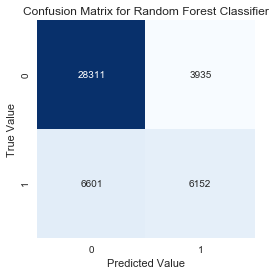

In [30]:
c_mtx = confusion_matrix(y_test, rfc_predictions)
sns.heatmap(c_mtx, square=True, annot=True, cbar=False, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')


The Random Forest Classifier is inaccurately overpredicting drunk drivers more often than sober ones. 

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

dt_pipeline(GradientBoostingClassifier(random_state=42))

Accuracy | Training :  0.789402921225
Accuracy | Test     :  0.787861952488


In [ ]:
grid.grid_scores_

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression().fit(X_train, y_train)
lgr_predictions = lgr.predict(X_test)
lgr_accuracy = accuracy_score(y_test, lgr_predictions)

lgr_accuracy

0.75790573123847194